# Automatic Image Captioning

--------------------------------
## Install additional libraries

In [ ]:
from IPython.display import clear_output
!pip install -q rouge-score
clear_output()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
!pip install opencv-python-headless




In [ ]:
!pip install torchtext
!pip install torch torchvision torchaudio


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from os.path import exists
import re
import string
import torch
import torch.nn as nn
from torch.autograd import Variable
import cv2
import torchvision
from torch.utils.data import DataLoader, random_split
from torchtext.data.metrics import bleu_score
from rouge_score import rouge_scorer
from collections import Counter
from tqdm import tqdm
import pickle
import nltk
from nltk.translate.bleu_score import sentence_bleu

import warnings
warnings.filterwarnings(action='ignore')

nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Check for GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load captions from dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/archive (4)/captions.txt', delimiter=',', dtype={'caption': str})
df.columns = ['image_name','comment']
print(df.shape)
df.head()

(40455, 2)


,image_name,comment
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


## Preprocessing of captions

### Text cleaning

In [ ]:
#remember: not removing stopwords, as we are learning entire sentence. We want to learn and predict stopwords too!
#also, can't lemmatize words as we are learning to generate sentences.

regex = re.compile('[%s]' % re.escape(string.punctuation))
def clean_text(row):
    row = str(row).strip()
    row = row.lower()
    return regex.sub("", row)

with tqdm(total=len(df['comment'].values)) as progress_bar:
    for i, caption in enumerate(df['comment'].values):
        newcaption = clean_text(caption)
        df['comment'].iloc[i] = newcaption
        progress_bar.update(1)
df['comment']

100%|██████████| 40455/40455 [00:14<00:00, 2730.90it/s]


0        a child in a pink dress is climbing up a set o...
1                     a girl going into a wooden building 
2          a little girl climbing into a wooden playhouse 
3        a little girl climbing the stairs to her playh...
4        a little girl in a pink dress going into a woo...
                               ...                        
40450             a man in a pink shirt climbs a rock face
40451              a man is rock climbing high in the air 
40452    a person in a red shirt climbing up a rock fac...
40453                       a rock climber in a red shirt 
40454    a rock climber practices on a rock climbing wall 
Name: comment, Length: 40455, dtype: object

### EDA of vocabulary

Vocabulary Size: 8828


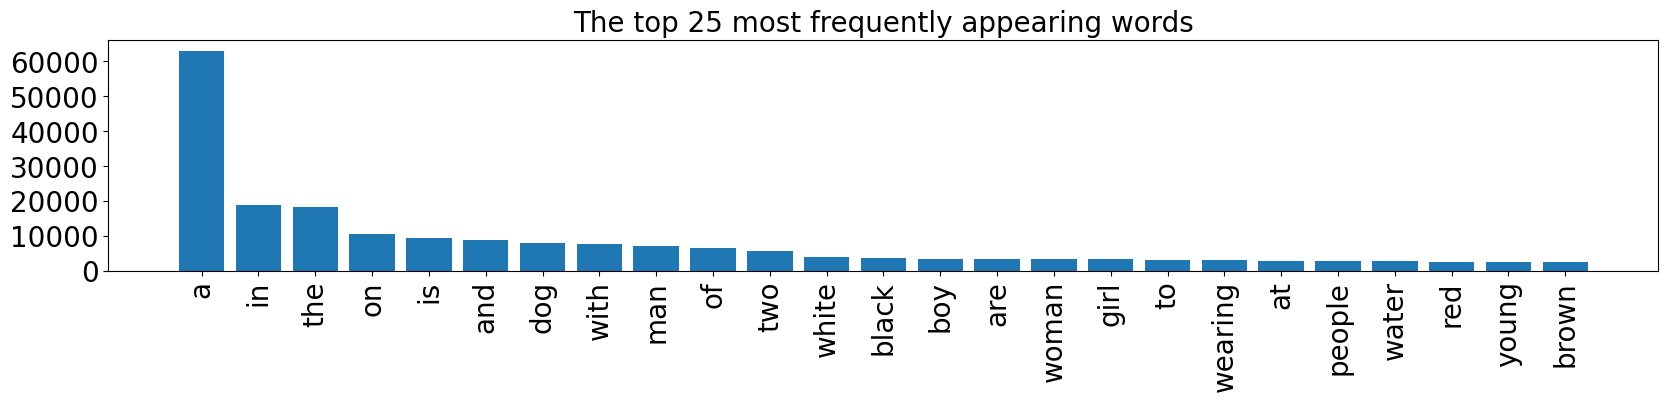

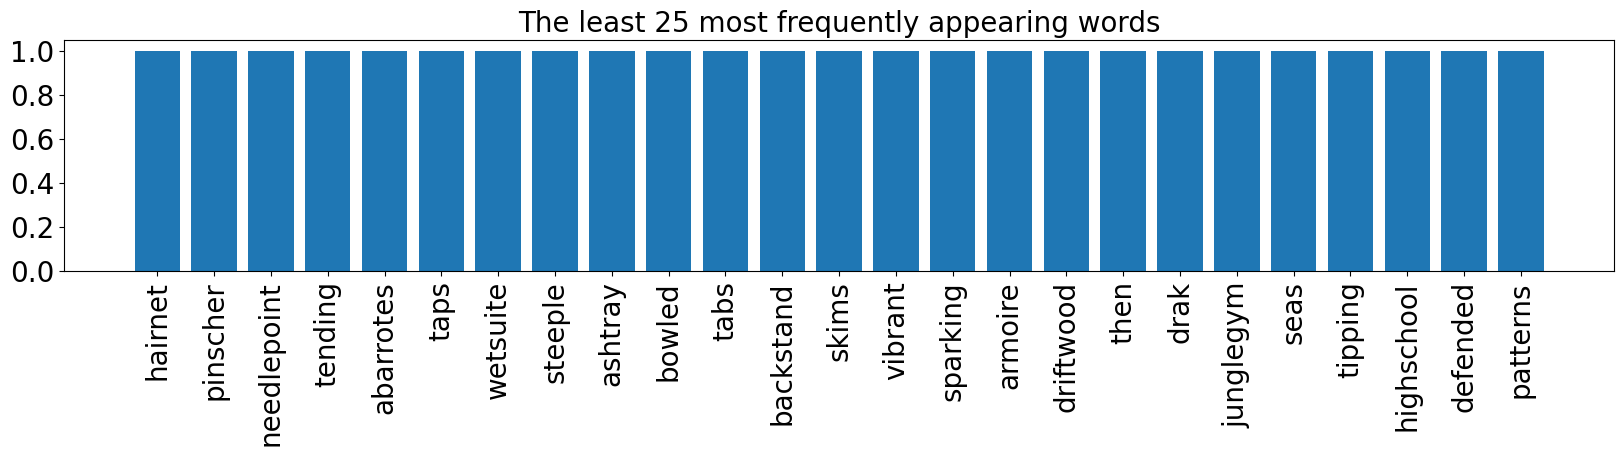

In [ ]:
def df_word(df_txt):
    vocabulary = []
    for i in range(len(df_txt)):
        temp=df_txt.iloc[i]
        vocabulary.extend(temp.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    del vocabulary
    return dfword

dfword = df_word(df['comment'])

topn = 25

def plthist(dfsub, title="The top {} most frequently appearing words".format(topn)):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top {} most frequently appearing words".format(topn))
plthist(dfword.iloc[-topn:,:],
        title="The least {} most frequently appearing words".format(topn))

### Create word frequency

In [ ]:
word_freq = {}
for caption in df['comment']:
    caption = caption.strip()
    for word in caption.split():
        if word not in word_freq:
            word_freq[word] = 0
        word_freq[word] += 1

### Build vocabulary

In [ ]:
def build_vocab(captions, word_freq, count_threshold=5):

    vocab = {
        "<pad>": 0,
        "<unk>": 1,
        "<sos>": 2,
        "<eos>": 3
    }
    index = 4

    for caption in captions:
        caption = caption.strip().split(" ")
        for word in caption:
            if word and word_freq[word] >= count_threshold and word not in vocab:
                vocab[word] = index
                index += 1

    inv_vocab = {v: k for k, v in vocab.items()}
    return vocab, inv_vocab

vocab, inv_vocab = build_vocab(df['comment'], word_freq)
print("Vocabulary size: {}".format(len(vocab)))

Vocabulary size: 2995


### Tokenize words into indices

In [ ]:
max_sen_len = 14
def convert_captions(captions, vocab, max_length=max_sen_len+2):
    tokens = [[vocab["<pad>"]]*max_length for _ in range(len(captions))]
    for i, caption in enumerate(captions):
        caption = caption.strip().split()
        tokens[i][0] = vocab["<sos>"]
        j = 1
        for word in caption[:max_length-2]:
            if word not in vocab:
                tokens[i][j] = vocab["<unk>"]
            else:
                tokens[i][j] = vocab[word]
            j += 1
        tokens[i][j] = vocab["<eos>"]
    return tokens
df['comment'] = convert_captions(df['comment'], vocab)
df.head()

,image_name,comment
0,1000268201_693b08cb0e.jpg,"[2, 4, 5, 6, 4, 7, 8, 9, 10, 11, 4, 12, 13, 14..."
1,1000268201_693b08cb0e.jpg,"[2, 4, 17, 18, 19, 4, 20, 21, 3, 0, 0, 0, 0, 0..."
2,1000268201_693b08cb0e.jpg,"[2, 4, 22, 17, 10, 19, 4, 20, 23, 3, 0, 0, 0, ..."
3,1000268201_693b08cb0e.jpg,"[2, 4, 22, 17, 10, 24, 14, 25, 26, 23, 3, 0, 0..."
4,1000268201_693b08cb0e.jpg,"[2, 4, 22, 17, 6, 4, 7, 8, 18, 19, 4, 20, 1, 3..."


## Build Image Caption Dataset Class and helper functions

In [ ]:
import os
from PIL import Image

IMG_DIR = "/content/drive/MyDrive/archive (4)/Images"
preloaded_images = {}

# Filter out directories from the list of files
image_files = [filename for filename in os.listdir(IMG_DIR) if os.path.isfile(os.path.join(IMG_DIR, filename))]

for filename in image_files:
    img_path = os.path.join(IMG_DIR, filename)
    with Image.open(img_path) as img:
        preloaded_images[filename] = img.copy()


In [83]:
class ImageCaptionDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, captions_csv, transform=None):
        self.root_dir = root_dir
        self.captions_csv = captions_csv
        self.transform = transform

    def __len__(self):
        return len(self.captions_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.captions_csv.iloc[idx, 0])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)

        caption = torch.LongTensor(self.captions_csv.iloc[idx, 1]).to(device)

        '''
            Ensure that the method returns a dictionary with keys 'image' and 'caption'.
        '''
        sample = {'image': image, 'caption': caption}

        return sample


class ImageCaptionDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, captions_csv, transform=None):
        self.root_dir = root_dir
        self.captions_csv = captions_csv
        self.transform = transform

    def __len__(self):
        return len(self.captions_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.captions_csv.iloc[idx, 0]
        full_img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(full_img_path)
        if self.transform:
            image = self.transform(image)

        caption = torch.LongTensor(self.captions_csv.iloc[idx, 1]).to(device)
        sample = {'image': image, 'caption': caption, 'filename': img_name}

        return sample

In [ ]:
def unnormalizeImage(img):

    if torch.is_tensor(img):
        img = img.cpu().detach().clone().numpy()

    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

    img = img.transpose((1, 2, 0))

    return img

### Generate dataset

In [ ]:

TRANSFORM_IMG = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
flickr_dataset = ImageCaptionDataset(root_dir=IMG_DIR, captions_csv=df, transform=TRANSFORM_IMG)
flickr_dataset



### Train-Dev-Test split

In [ ]:
BATCH_SIZE = 100
NUM_WORKERS = 0

n_val = int(np.floor(0.05 * len(flickr_dataset)))
n_test = int(np.floor(0.05 * len(flickr_dataset)))
n_train = len(flickr_dataset) - n_val - n_test
dl_args = dict(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

train_ds, val_ds, test_ds = random_split(flickr_dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(20))

train_dl = DataLoader(train_ds, **dl_args)
valid_dl = DataLoader(val_ds, **dl_args)
test_dl = DataLoader(test_ds, **dl_args)

print("no of batches in train set: {}".format(len(train_dl)))
print("no of batches in valid set: {}".format(len(valid_dl)))
print("no of batches in test set: {}".format(len(test_dl)))

no of batches in train set: 365
no of batches in valid set: 21
no of batches in test set: 21


## Build Model

The block diagram of model is shown below:

![Image Caption Model - Block Diagram](attachment:16932c49-e15a-4847-bf74-991dcb10158a.png)

### Image Encoder Class

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, hidd_dim):
        super().__init__()
        self.cnn = torch.nn.Sequential(*(list(torchvision.models.resnet101(pretrained=True).children())[:-1]),
                                      nn.Flatten())
        self.cnn.eval()
        self.fc = nn.Linear(2048, hidd_dim)

    def forward(self, img):
        img = self.cnn(img)
        img = self.fc(img)
        return img

### Caption Decoder Class

In [ ]:
class CaptionDecoder(nn.Module):
    def __init__(self, n_vocab, hidd_dim, max_sen_len, emb_dim, p):
        super().__init__()
        self.max_sen_len = max_sen_len
        self.emb = nn.Embedding(num_embeddings=n_vocab, embedding_dim=emb_dim, padding_idx=0)

        self.lstm = nn.LSTM(input_size=emb_dim,
                            hidden_size=hidd_dim,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=False,
                            dropout=p)
        self.fc_text = nn.Linear(hidd_dim, n_vocab)
        self.soft = nn.Softmax(dim=-1)

    def forward(self, x, img, predict_mode=False):
        img = torch.stack([img]*(self.lstm.num_layers), dim=0).to(device)
        if predict_mode:
            output = []
            h0 = img
            c0 = img
            while x != vocab["<eos>"] and len(output) <= self.max_sen_len:
                x = torch.tensor([[x]]).to(device)
                x = self.emb(x)
                out, (h0, c0) = self.lstm(x, (h0, c0))
                out = self.fc_text(out)
                out = self.soft(out)
                out = torch.argmax(out, dim=-1)
                x = out.squeeze().item()
                output.append(x)
            output = torch.tensor(output).to(device)
        else:
            x = self.emb(x)
            output, (h0, c0) = self.lstm(x, (img, img))
            output = self.fc_text(output)
        return output

### Image Caption Model Class

In [ ]:
class ImgCaptionModel(nn.Module):
    def __init__(self, n_vocab, hidd_dim, max_sen_len, emb_dim, p=0):
        super().__init__()
        self.encoder = ImageEncoder(hidd_dim).to(device)
        self.decoder = CaptionDecoder(n_vocab, hidd_dim, max_sen_len, emb_dim, p).to(device)

    def predict(self, img):
        img = self.encoder(img)
        cap = vocab["<sos>"]
        yhat = self.decoder(cap, img, predict_mode=True)

        pred_sen = [inv_vocab[t.item()] for t in yhat]
        pred_sen = " ".join(pred_sen)
        return pred_sen

    def forward(self, sample):
        '''
            sample: dict of image & caption
        '''
        img = sample['image'].to(device)
        cap = sample['caption'].to(device)

        '''---For Image---'''
        img = self.encoder(img)

        '''---For Text---'''
        yhat = self.decoder(cap[:, :-1], img, predict_mode=False)
        yhat = yhat.permute(0, 2, 1)
        return yhat

### Define helper functions

In [ ]:
def train(model, sample, loss_fn, optimizer):
    model.train()

    cap = sample['caption'].to(device)
    yhat = model(sample)

    loss = loss_fn(yhat, cap[:,1:])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def test(model, sample, i, loss_fn):
    model.eval()
    with torch.no_grad():
        cap = sample['caption'].to(device)
        yhat = model(sample)
        loss = loss_fn(yhat, cap[:,1:])

    return loss.item()

def predict(model, sample, i, plot_img=False):
    model.eval()
    with torch.no_grad():
        img = sample['image'][i].to(device)
        if plot_img:
            plt.imshow(unnormalizeImage(img))
            plt.xticks([])
            plt.yticks([])
            plt.show()
        pred_sen = model.predict(img.unsqueeze(0))

    return pred_sen

def sample_output(model, ds=test_ds):
    with torch.no_grad():
        j = np.random.randint(low=0,high=len(ds))
        img = ds[j]['image']
        true_ans = ds[j]['caption']
        sp = {'image': img.unsqueeze(0), 'caption':true_ans.unsqueeze(0)}
        pred_ans = predict(model, sp, 0, plot_img=True)

        true_ans = [inv_vocab[t.item()] for t in true_ans if t not in [0,2,3]]
        rc = [true_ans]
        true_ans = " ".join(true_ans)
        print("true: {}".format(true_ans))
        print("prediction: {}".format(pred_ans))

        #bleu scores
        cc = pred_ans.split(' ')
        cc = [ps for ps in cc if ps not in ['<sos>', '<eos>', '<pad>']]
        b1 = sentence_bleu(rc,cc,weights=(1,0,0,0))
        b2 = sentence_bleu(rc,cc,weights=(0.5,0.5,0,0))
        b3 = sentence_bleu(rc,cc,weights=(1/3,1/3,1/3,0))
        b4 = sentence_bleu(rc,cc,weights=(0.25, 0.25, 0.25, 0.25))
        print("BLEU-1: {:.2f}\nBLEU-2: {:.2f}\nBLEU-3: {:.2f}\nBLEU-4: {:.2f}".format(b1,b2,b3,b4))


        #rouge scores
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        pred_ans = pred_ans.split(' ')
        pred_ans = " ".join([p for p in pred_ans if p not in ['<sos>', '<eos>', '<pad>']])
        r = scorer.score(true_ans,pred_ans)
        r1 = r['rouge1']
        r2 = r['rouge2']
        rl = r['rougeL']
        print("ROUGE-1: {}\nROUGE-2: {}\nROUGE-l: {}".format(r1,r2,rl))

        #meteor scores
        m1 = nltk.translate.meteor_score.meteor_score([[true_ans]],[pred_ans])
        print("METEOR: {:.2f}".format(m1))

## Training the Model

In [ ]:
model = ImgCaptionModel(n_vocab=len(vocab), hidd_dim=512, max_sen_len=max_sen_len+2, emb_dim=32, p=0).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 30
print(model)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 167MB/s]


ImgCaptionModel(
  (encoder): ImageEncoder(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
 

In [26]:
train_loss = []
valid_loss = []
B1 = []
B2 = []
B3 = []
B4 = []
R1 = []
R2 = []
RL = []
M = []
best_loss = torch.inf
best_model = dict()

for i in range(epochs):
    '''
    Training on train set
    '''
    print("--- Epoch {} ---".format(i+1))
    epoch_loss = 0
    m = len(train_dl)
    with tqdm(total=m) as progress_bar:
        for sample in train_dl:
            epoch_loss += train(model, sample, loss_fn, optimizer)
            progress_bar.update(1)
    print("\tLoss (Training) : {}".format(epoch_loss/m))
    train_loss.append(epoch_loss/m)

    '''
    Testing on dev set
    '''
    val_loss = 0
    with tqdm(total=len(valid_dl)) as progress_bar1:
        for j in range(len(valid_dl)):
            vl = test(model, sample, j, loss_fn)
            if vl < best_loss:
                best_loss = vl
                best_model = model.state_dict()
            val_loss += vl
            progress_bar1.update(1)
    print("\tLoss (Validation) : {}".format(val_loss/len(valid_dl)))
    valid_loss.append(val_loss/len(valid_dl))

    '''
    Computing sentence generation metrics on dev set
    '''
    with tqdm(total=len(val_ds)) as progress_bar2:
        for j in range(len(val_ds)):
            with torch.no_grad():
                img = val_ds[j]['image']
                true_ans = val_ds[j]['caption']
                sp = {'image': img.unsqueeze(0), 'caption':true_ans.unsqueeze(0)}
                pred_ans = predict(model, sp, 0)

                true_ans = [inv_vocab[t.item()] for t in true_ans if t not in [0,2,3]]
                rc = [true_ans]
                true_ans = " ".join(true_ans)

                # bleu scores
                cc = pred_ans.split(' ')
                cc = [ps for ps in cc if ps not in ['<sos>', '<eos>', '<pad>']]
                b1 = sentence_bleu(rc,cc,weights=(1,0,0,0))
                b2 = sentence_bleu(rc,cc,weights=(0.5,0.5,0,0))
                b3 = sentence_bleu(rc,cc,weights=(1/3,1/3,1/3,0))
                b4 = sentence_bleu(rc,cc,weights=(0.25, 0.25, 0.25, 0.25))
                B1.append(b1)
                B2.append(b2)
                B3.append(b3)
                B4.append(b4)

                # rouge scores
                scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
                pred_ans = pred_ans.split(' ')
                pred_ans = " ".join([p for p in pred_ans if p not in ['<sos>', '<eos>', '<pad>']])
                r = scorer.score(true_ans, pred_ans)
                r1 = r['rouge1']
                r2 = r['rouge2']
                rl = r['rougeL']
                R1.append(r1.fmeasure)
                R2.append(r2.fmeasure)
                RL.append(rl.fmeasure)

                # meteor scores
                m1 = nltk.translate.meteor_score.meteor_score([[true_ans]], [pred_ans])
                M.append(m1)
            progress_bar2.update(1)

--- Epoch 1 ---


100%|██████████| 365/365 [07:59<00:00,  1.31s/it]


	Loss (Training) : 3.3863718045900946


100%|██████████| 21/21 [00:00<00:00, 42.77it/s]


	Loss (Validation) : 3.066277821858724


100%|██████████| 2022/2022 [01:26<00:00, 23.39it/s]


--- Epoch 2 ---


100%|██████████| 365/365 [07:56<00:00,  1.31s/it]


	Loss (Training) : 2.690656629327225


100%|██████████| 21/21 [00:00<00:00, 43.46it/s]


	Loss (Validation) : 2.7489850634620305


100%|██████████| 2022/2022 [01:25<00:00, 23.71it/s]


--- Epoch 3 ---


100%|██████████| 365/365 [07:55<00:00,  1.30s/it]


	Loss (Training) : 2.4685250047135026


100%|██████████| 21/21 [00:00<00:00, 42.92it/s]


	Loss (Validation) : 2.12019673983256


100%|██████████| 2022/2022 [01:25<00:00, 23.61it/s]


--- Epoch 4 ---


100%|██████████| 365/365 [07:55<00:00,  1.30s/it]


	Loss (Training) : 2.332684455505789


100%|██████████| 21/21 [00:00<00:00, 43.65it/s]


	Loss (Validation) : 2.240424621672857


100%|██████████| 2022/2022 [01:23<00:00, 24.29it/s]


--- Epoch 5 ---


100%|██████████| 365/365 [07:53<00:00,  1.30s/it]


	Loss (Training) : 2.23215793550831


100%|██████████| 21/21 [00:00<00:00, 43.68it/s]


	Loss (Validation) : 2.2110943567185175


100%|██████████| 2022/2022 [01:23<00:00, 24.13it/s]


--- Epoch 6 ---


100%|██████████| 365/365 [07:53<00:00,  1.30s/it]


	Loss (Training) : 2.149567209857784


100%|██████████| 21/21 [00:00<00:00, 43.38it/s]


	Loss (Validation) : 1.8936368340537661


100%|██████████| 2022/2022 [01:22<00:00, 24.37it/s]


--- Epoch 7 ---


100%|██████████| 365/365 [07:52<00:00,  1.29s/it]


	Loss (Training) : 2.0750988653261366


100%|██████████| 21/21 [00:00<00:00, 43.39it/s]


	Loss (Validation) : 1.793959827650161


100%|██████████| 2022/2022 [01:23<00:00, 24.25it/s]


--- Epoch 8 ---


100%|██████████| 365/365 [07:52<00:00,  1.29s/it]


	Loss (Training) : 2.00981966534706


100%|██████████| 21/21 [00:00<00:00, 43.60it/s]


	Loss (Validation) : 2.1771314711797807


100%|██████████| 2022/2022 [01:24<00:00, 24.03it/s]


--- Epoch 9 ---


100%|██████████| 365/365 [07:49<00:00,  1.29s/it]


	Loss (Training) : 1.9482632748068196


100%|██████████| 21/21 [00:00<00:00, 43.79it/s]


	Loss (Validation) : 1.7972163018726168


100%|██████████| 2022/2022 [01:21<00:00, 24.86it/s]


--- Epoch 10 ---


100%|██████████| 365/365 [07:49<00:00,  1.29s/it]


	Loss (Training) : 1.8880198468900706


100%|██████████| 21/21 [00:00<00:00, 43.11it/s]


	Loss (Validation) : 1.6805741786956787


100%|██████████| 2022/2022 [01:22<00:00, 24.48it/s]


--- Epoch 11 ---


100%|██████████| 365/365 [07:47<00:00,  1.28s/it]


	Loss (Training) : 1.8299752885348177


100%|██████████| 21/21 [00:00<00:00, 43.63it/s]


	Loss (Validation) : 1.707581877708435


100%|██████████| 2022/2022 [01:21<00:00, 24.94it/s]


--- Epoch 12 ---


100%|██████████| 365/365 [07:46<00:00,  1.28s/it]


	Loss (Training) : 1.7755276180293462


100%|██████████| 21/21 [00:00<00:00, 43.05it/s]


	Loss (Validation) : 1.6568382070178078


100%|██████████| 2022/2022 [01:20<00:00, 25.19it/s]


--- Epoch 13 ---


100%|██████████| 365/365 [07:46<00:00,  1.28s/it]


	Loss (Training) : 1.7221854415658402


100%|██████████| 21/21 [00:00<00:00, 43.68it/s]


	Loss (Validation) : 1.729043268022083


100%|██████████| 2022/2022 [01:20<00:00, 25.18it/s]


--- Epoch 14 ---


100%|██████████| 365/365 [07:48<00:00,  1.28s/it]


	Loss (Training) : 1.670703486873679


100%|██████████| 21/21 [00:00<00:00, 42.93it/s]


	Loss (Validation) : 1.3203526508240473


100%|██████████| 2022/2022 [01:21<00:00, 24.73it/s]


--- Epoch 15 ---


100%|██████████| 365/365 [07:47<00:00,  1.28s/it]


	Loss (Training) : 1.6202641660220003


100%|██████████| 21/21 [00:00<00:00, 43.48it/s]


	Loss (Validation) : 1.5185391108194988


100%|██████████| 2022/2022 [01:21<00:00, 24.69it/s]


--- Epoch 16 ---


100%|██████████| 365/365 [07:52<00:00,  1.29s/it]


	Loss (Training) : 1.5724799361947464


100%|██████████| 21/21 [00:00<00:00, 43.48it/s]


	Loss (Validation) : 1.3361237049102783


100%|██████████| 2022/2022 [01:22<00:00, 24.61it/s]


--- Epoch 17 ---


100%|██████████| 365/365 [07:53<00:00,  1.30s/it]


	Loss (Training) : 1.5287784151834984


100%|██████████| 21/21 [00:00<00:00, 43.16it/s]


	Loss (Validation) : 1.186837605067662


100%|██████████| 2022/2022 [01:22<00:00, 24.48it/s]


--- Epoch 18 ---


100%|██████████| 365/365 [07:53<00:00,  1.30s/it]


	Loss (Training) : 1.4820752055677648


100%|██████████| 21/21 [00:00<00:00, 43.55it/s]


	Loss (Validation) : 1.3793459790093558


100%|██████████| 2022/2022 [01:23<00:00, 24.20it/s]


--- Epoch 19 ---


100%|██████████| 365/365 [07:57<00:00,  1.31s/it]


	Loss (Training) : 1.4411534564135826


100%|██████████| 21/21 [00:00<00:00, 43.58it/s]


	Loss (Validation) : 1.430549286660694


100%|██████████| 2022/2022 [01:24<00:00, 24.05it/s]


--- Epoch 20 ---


100%|██████████| 365/365 [07:51<00:00,  1.29s/it]


	Loss (Training) : 1.3985447194478282


100%|██████████| 21/21 [00:00<00:00, 43.38it/s]


	Loss (Validation) : 1.3177496194839478


100%|██████████| 2022/2022 [01:23<00:00, 24.30it/s]


--- Epoch 21 ---


100%|██████████| 365/365 [07:53<00:00,  1.30s/it]


	Loss (Training) : 1.3582332127714811


100%|██████████| 21/21 [00:00<00:00, 43.51it/s]


	Loss (Validation) : 1.1946719884872437


100%|██████████| 2022/2022 [01:22<00:00, 24.45it/s]


--- Epoch 22 ---


100%|██████████| 365/365 [07:50<00:00,  1.29s/it]


	Loss (Training) : 1.3198806553670805


100%|██████████| 21/21 [00:00<00:00, 43.56it/s]


	Loss (Validation) : 1.2048278479349046


100%|██████████| 2022/2022 [01:21<00:00, 24.72it/s]


--- Epoch 23 ---


100%|██████████| 365/365 [07:52<00:00,  1.29s/it]


	Loss (Training) : 1.280642923916856


100%|██████████| 21/21 [00:00<00:00, 43.26it/s]


	Loss (Validation) : 0.9321740354810443


100%|██████████| 2022/2022 [01:21<00:00, 24.84it/s]


--- Epoch 24 ---


100%|██████████| 365/365 [07:47<00:00,  1.28s/it]


	Loss (Training) : 1.2440481770528506


100%|██████████| 21/21 [00:00<00:00, 43.54it/s]


	Loss (Validation) : 0.9964584537914821


100%|██████████| 2022/2022 [01:21<00:00, 24.70it/s]


--- Epoch 25 ---


100%|██████████| 365/365 [07:56<00:00,  1.30s/it]


	Loss (Training) : 1.2094492784918172


100%|██████████| 21/21 [00:00<00:00, 43.51it/s]


	Loss (Validation) : 1.1047599031811668


100%|██████████| 2022/2022 [01:25<00:00, 23.59it/s]


--- Epoch 26 ---


100%|██████████| 365/365 [07:53<00:00,  1.30s/it]


	Loss (Training) : 1.1768442104940544


100%|██████████| 21/21 [00:00<00:00, 42.97it/s]


	Loss (Validation) : 0.8624797633716038


100%|██████████| 2022/2022 [01:21<00:00, 24.68it/s]


--- Epoch 27 ---


100%|██████████| 365/365 [07:48<00:00,  1.28s/it]


	Loss (Training) : 1.1443519219960252


100%|██████████| 21/21 [00:00<00:00, 43.58it/s]


	Loss (Validation) : 0.9510430835542225


100%|██████████| 2022/2022 [01:22<00:00, 24.38it/s]


--- Epoch 28 ---


100%|██████████| 365/365 [07:48<00:00,  1.28s/it]


	Loss (Training) : 1.1100248585008594


100%|██████████| 21/21 [00:00<00:00, 43.63it/s]


	Loss (Validation) : 1.0172621919995262


100%|██████████| 2022/2022 [01:22<00:00, 24.58it/s]


--- Epoch 29 ---


100%|██████████| 365/365 [07:49<00:00,  1.29s/it]


	Loss (Training) : 1.079548933897933


100%|██████████| 21/21 [00:00<00:00, 43.39it/s]


	Loss (Validation) : 0.9489940234592983


100%|██████████| 2022/2022 [01:21<00:00, 24.73it/s]


--- Epoch 30 ---


100%|██████████| 365/365 [07:49<00:00,  1.29s/it]


	Loss (Training) : 1.051004893975715


100%|██████████| 21/21 [00:00<00:00, 42.75it/s]


	Loss (Validation) : 0.8369755943616232


100%|██████████| 2022/2022 [01:22<00:00, 24.62it/s]


## Save results & best model

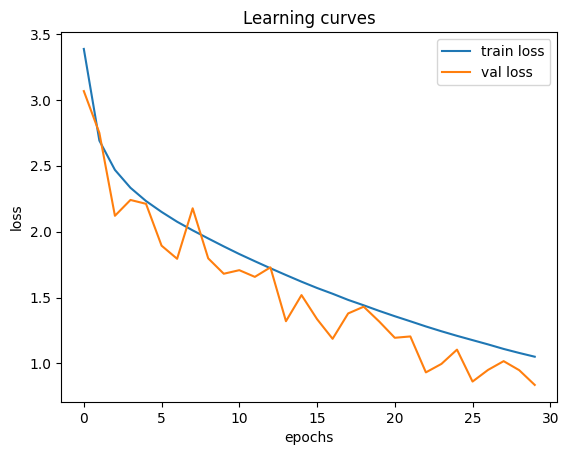

In [27]:
plt.plot(range(len(train_loss)),train_loss, label='train loss')
plt.plot(range(len(valid_loss)),valid_loss, label='val loss')
plt.title("Learning curves")
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [28]:
torch.save(best_model, 'best_model_weights8k.h5')
print("Weights of best model saved successfully!")

Weights of best model saved successfully!


In [29]:
def process_results(res):
    r = []
    m = int(res.shape[0]/epochs)
    for i in range(epochs):
        r.append(res[i*m:(i+1)*m].to_numpy())
    r = np.array(r).mean(axis=1)
    return r

df_metrics = pd.DataFrame({
    'B1':B1,
    'B2':B2,
    'B3':B3,
    'B4':B4,
    'R1':R1,
    'R2':R2,
    'RL':RL,
    'M':M
})
df_metrics = df_metrics.apply(process_results,axis=0)*100
df_metrics.to_csv('results8k.csv', index=False)

df_loss = pd.DataFrame({
    'train_loss':train_loss,
    'valid_loss':valid_loss
})
df_loss = df_loss.apply(process_results,axis=0)
df_loss.to_csv('loss8k.csv', index=False)
print("Results saved successfully!")

Results saved successfully!


### Plot results

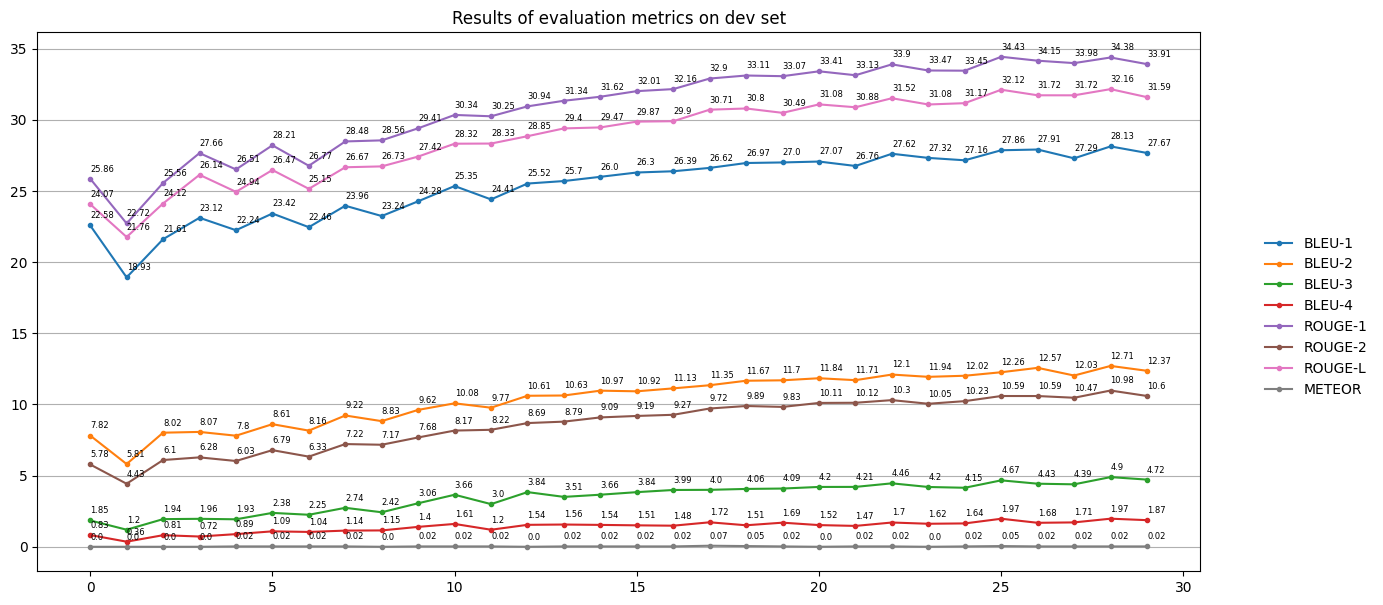

In [30]:
x = range(epochs)
plt.figure(figsize=(15,7))
plt.plot(x, df_metrics['B1'], label='BLEU-1', marker='.')
plt.plot(x, df_metrics['B2'], label='BLEU-2', marker='.')
plt.plot(x, df_metrics['B3'], label='BLEU-3', marker='.')
plt.plot(x, df_metrics['B4'], label='BLEU-4', marker='.')
plt.plot(x, df_metrics['R1'], label='ROUGE-1', marker='.')
plt.plot(x, df_metrics['R2'], label='ROUGE-2', marker='.')
plt.plot(x, df_metrics['RL'], label='ROUGE-L', marker='.')
plt.plot(x, df_metrics['M'], label='METEOR', marker='.')
plt.title("Results of evaluation metrics on dev set")
plt.legend(loc='lower center', bbox_to_anchor=(1.1, 0.3), ncol=1).get_frame().set_linewidth(0.0)
plt.grid(axis='y')

for c in df_metrics.columns.tolist():
    for idx,val in enumerate(df_metrics[c].to_numpy()):
        plt.text(idx,val+0.5, str(np.round_(val,2)), color='black', fontsize=6)
plt.show()

## Generate sample outputs from test set using best weights

In [31]:
bestmodel = ImgCaptionModel(n_vocab=len(vocab), hidd_dim=512, max_sen_len=16, emb_dim=32, p=0).to(device)
bestmodel.load_state_dict(torch.load('./best_model_weights8k.h5'))
print("Best weights loaded successfully!")

Best weights loaded successfully!


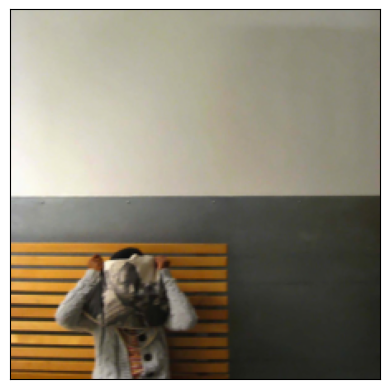

true: the person blocks his face with newspaper to avoid being photographed
prediction: a woman stands on a rocky ledge overlooking a body of water <eos>
BLEU-1: 0.00
BLEU-2: 0.00
BLEU-3: 0.00
BLEU-4: 0.00
ROUGE-1: Score(precision=0.0, recall=0.0, fmeasure=0.0)
ROUGE-2: Score(precision=0.0, recall=0.0, fmeasure=0.0)
ROUGE-l: Score(precision=0.0, recall=0.0, fmeasure=0.0)
METEOR: 0.00


In [71]:
sample_output(bestmodel)

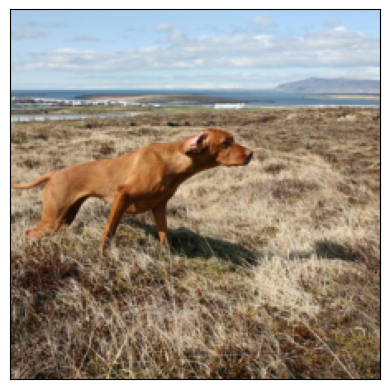

true: a brown dog in a field
prediction: a dog walks along a rocky terrain <eos>
BLEU-1: 0.43
BLEU-2: 0.00
BLEU-3: 0.00
BLEU-4: 0.00
ROUGE-1: Score(precision=0.42857142857142855, recall=0.5, fmeasure=0.4615384615384615)
ROUGE-2: Score(precision=0.0, recall=0.0, fmeasure=0.0)
ROUGE-l: Score(precision=0.42857142857142855, recall=0.5, fmeasure=0.4615384615384615)
METEOR: 0.00


In [70]:
sample_output(bestmodel)

In [37]:
import os
os.listdir('.')


['.config',
 'loss8k.csv',
 'results8k.csv',
 'best_model_weights8k.h5',
 'drive',
 'sample_data']

In [40]:
from google.colab import files
 # Download the results CSV file
files.download('best_model_weights8k.h5')    # Download the loss CSV file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
import numpy as np

# Calculate mean scores for all metrics
mean_train_loss = np.mean(train_loss)
mean_valid_loss = np.mean(valid_loss)
mean_B1 = np.mean(B1)
mean_B2 = np.mean(B2)
mean_B3 = np.mean(B3)
mean_B4 = np.mean(B4)
mean_R1 = np.mean(R1)
mean_R2 = np.mean(R2)
mean_RL = np.mean(RL)
mean_M = np.mean(M)

# Print the results
print(f"Average Training Loss: {mean_train_loss:.4f}")
print(f"Average Validation Loss: {mean_valid_loss:.4f}")
print("Average BLEU-1 Score:", mean_B1)
print("Average BLEU-2 Score:", mean_B2)
print("Average BLEU-3 Score:", mean_B3)
print("Average BLEU-4 Score:", mean_B4)
print("Average ROUGE-1 Score:", mean_R1)
print("Average ROUGE-2 Score:", mean_R2)
print("Average ROUGE-L Score:", mean_RL)
print("Average METEOR Score:", mean_M)


Average Training Loss: 1.7066
Average Validation Loss: 1.5454
Average BLEU-1 Score: 0.2536190948494802
Average BLEU-2 Score: 0.10411442307840107
Average BLEU-3 Score: 0.03456727156773104
Average BLEU-4 Score: 0.013980531827302778
Average ROUGE-1 Score: 0.3085669224467127
Average ROUGE-2 Score: 0.08623649680885356
Average ROUGE-L Score: 0.28821198565003453
Average METEOR Score: 0.0002143092647543686


In [54]:
import pandas as pd

# Create a DataFrame from the averages
df_metrics_summary = pd.DataFrame({
    'Metric': ['Train Loss', 'Validation Loss', 'BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR'],
    'Average Score': [mean_train_loss, mean_valid_loss, mean_B1, mean_B2, mean_B3, mean_B4, mean_R1, mean_R2, mean_RL, mean_M]
})

# Save to CSV
df_metrics_summary.to_csv('/content/drive/MyDrive/archive (4)/evaluation_metrics_summary.csv', index=False)
print("Saved evaluation metrics summary to 'evaluation_metrics_summary.csv'.")


Saved evaluation metrics summary to 'evaluation_metrics_summary.csv'.


In [68]:
def predict(model, sample, i, plot_img=False):
    model.eval()
    with torch.no_grad():
        img = sample['image'][i].to(device)  # Select the i-th image in the batch/sample
        if plot_img:
            plt.imshow(unnormalizeImage(img))
            plt.xticks([])
            plt.yticks([])
            plt.show()
        pred_sen = model.predict(img.unsqueeze(0))  # Predict the caption for the image

    return pred_sen


In [73]:

def generate_and_save_predictions(model, data_loader, output_file):
    # Ensure the model is in evaluation mode
    model.eval()

    # List to hold the image filenames and their predicted captions
    results = []

    # No gradients needed
    with torch.no_grad():
        for sample in data_loader:
            images = sample['image'].to(device)
            filenames = sample['filename']  # Assuming your dataset provides filenames

            # Generate predictions for each image
            for idx, image in enumerate(images):
                # Predict the caption for the current image
                # The prediction function should be adapted if it takes different parameters
                predicted_caption = predict(model, {'image': image.unsqueeze(0)}, 0)

                # Append the result as a tuple (filename, predicted caption)
                results.append((filenames[idx], predicted_caption))

    # Create a DataFrame from the results
    df = pd.DataFrame(results, columns=['image', 'predicted'])

    # Save the DataFrame to a CSV file
    df.to_csv(output_file, index=False)
    print(f"Saved predictions to {output_file}")



In [86]:
class ImageCaptionDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, captions_csv, transform=None):
        self.root_dir = root_dir
        self.captions_csv = captions_csv
        self.transform = transform

    def __len__(self):
        return len(self.captions_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.captions_csv.iloc[idx, 0]
        full_img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(full_img_path)
        if self.transform:
            image = self.transform(image)

        caption = torch.LongTensor(self.captions_csv.iloc[idx, 1]).to(device)
        sample = {'image': image, 'caption': caption, 'filename': img_name}

        return sample


In [88]:
pip install pycocoevalcap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 16.2 MB/s eta 0:00:00


In [92]:
predictions = {}
references = {}

# Assuming you have a DataLoader `valid_dl` setup for validation
for data in valid_dl:
    images = data['image'].to(device)
    img_ids = data['filename']  # Ensure your DataLoader provides filenames or IDs
    true_captions = data['caption']  # Adjust based on how true captions are provided

    # Model prediction (assuming your predict function is ready)
    predicted_captions = [predict(model, {'image': img.unsqueeze(0)}, 0) for img in images]

    for img_id, pred_caption, true_caption in zip(img_ids, predicted_captions, true_captions):
        if img_id not in predictions:
            predictions[img_id] = [pred_caption]
        if img_id not in references:
            references[img_id] = [true_caption]
        else:
            references[img_id].append(true_caption)


KeyError: 'filename'

In [91]:
class ImageCaptionDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, captions_csv, transform=None):
        self.root_dir = root_dir
        self.captions_csv = captions_csv
        self.transform = transform

    def __len__(self):
        return len(self.captions_csv)

    def __getitem__(self, idx):
        img_name = self.captions_csv.iloc[idx, 0]  # Image filename
        caption = self.captions_csv.iloc[idx, 1]  # Caption
        full_img_path = os.path.join(self.root_dir, img_name)

        image = Image.open(full_img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return {
            'image': image,
            'caption': caption,
            'filename': img_name  # Include the filename in the returned dictionary
        }


In [97]:
import os
import zipfile
from PIL import Image

def save_predictions_with_images(data_loader, model, output_dir):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Create a ZIP file to store the images and captions
    zip_filename = os.path.join(output_dir, 'predicted_captions_and_images.zip')
    with zipfile.ZipFile(zip_filename, 'w') as myzip:
        # Iterate through the data loader
        for idx, data in enumerate(data_loader):
            image = data['image'].to(device)
            image_id = f"image_{idx}"
            caption = model.predict(image)  # Adjust this line based on your prediction function

            # Save the image
            image_path = os.path.join(output_dir, f"{image_id}.png")
            image_data = Image.fromarray(image.cpu().numpy().transpose((1, 2, 0)))
            image_data.save(image_path)
            myzip.write(image_path, arcname=f"{image_id}.png")  # Add image to ZIP

            # Write the caption to a text file inside the ZIP
            caption_file = f"{image_id}_caption.txt"
            caption_path = os.path.join(output_dir, caption_file)
            with open(caption_path, 'w') as file:
                file.write(caption)
            myzip.write(caption_path, arcname=caption_file)  # Add caption file to ZIP

            # Clean up by removing the files after adding to the zip
            os.remove(image_path)
            os.remove(caption_path)

    print(f"Saved images and captions to {zip_filename}")

# Usage example
save_predictions_with_images(valid_dl, model, '/content/drive/MyDrive/archive (4)/output')


OutOfMemoryError: CUDA out of memory. Tried to allocate 58.00 MiB. GPU 0 has a total capacity of 15.77 GiB of which 22.38 MiB is free. Process 49481 has 15.75 GiB memory in use. Of the allocated memory 14.87 GiB is allocated by PyTorch, and 497.10 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)